In [1]:
# connect to google drive, run this block again after every restart of runtime
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Regularizer_model_0109')

Mounted at /content/drive


In [2]:
# !pip install matplotlib==3.1.1

In [3]:
import os
import h5py
import time
import csv
import glob

import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras

from numpy import load
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import Conv3DTranspose
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ELU
from tensorflow.keras.activations import linear
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import epsilon

import matplotlib
from matplotlib import pyplot
import matplotlib.pylab as plt
import seaborn as sns

In [4]:
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.7.1


In [5]:
# review (only review) GPU information, run when needed
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Sep  9 18:59:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# define an encoder block
def encoder_block(layer_in, n_filters, strd=(2,2,2), batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv3D(n_filters, (3,3,3), strides=strd, padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [7]:
# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, strd=(2,2,2), dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv3DTranspose(n_filters, (3,3,3), strides=strd, padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

In [8]:
# define the standalone generator model
def define_generator(src_image_shape=(128,128,32,4)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=src_image_shape) # 128*128*32*5

    # encoder model
    e0 = encoder_block(in_image, 128, strd=(1,1,1), batchnorm=True) # 128*128*32*128
    e1 = encoder_block(e0, 128, strd=(1,1,1), batchnorm=True) # 128*128*32*128
    e2 = encoder_block(e1, 128, strd=(1,1,1), batchnorm=True) # 128*128*32*128
    e3 = encoder_block(e2, 256, strd=(2,2,2), batchnorm=True) # 64*64*16*256
    e4 = encoder_block(e3, 256, strd=(1,1,1), batchnorm=True) # 64*64*16*256
    e4_ = encoder_block(e4, 256, strd=(1,1,1), batchnorm=True) # 64*64*16*256
    e5 = encoder_block(e4_, 512, strd=(2,2,2), batchnorm=True) # 32*32*8*512
    e6 = encoder_block(e5, 512, strd=(1,1,1), batchnorm=True) # 32*32*8*512
    e6_ = encoder_block(e6, 512, strd=(1,1,1), batchnorm=True) # 32*32*8*512
    e7 = encoder_block(e6_, 512, strd=(2,2,2), batchnorm=True) # 16*16*4*512
    e8 = encoder_block(e7, 512, strd=(1,1,1), batchnorm=True) # 16*16*4*512
    e8_ = encoder_block(e8, 512, strd=(1,1,1), batchnorm=True) # 16*16*4*512

    # bottleneck
    b = encoder_block(e8_, 512, strd=(2,2,2), batchnorm=True) # 8*8*2*512

    # decoder model
    d9 = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(b)  # 8*8*2*512
    d9 = BatchNormalization()(d9)
    # d9 = Dropout(0.5)(d9)
    d9 = LeakyReLU(alpha=0.2)(d9)

    d9_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d9)  # 8*8*2*512
    d9_ = BatchNormalization()(d9_)
    # d9_ = Dropout(0.5)(d9_)
    d9_ = LeakyReLU(alpha=0.2)(d9_)

    d8 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d9_)  # 16*16*4*512
    d8 = BatchNormalization()(d8)
    d8 = LeakyReLU(alpha=0.2)(d8)

    d8_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d8)  # 16*16*4*512
    d8_ = BatchNormalization()(d8_)
    d8_ = LeakyReLU(alpha=0.2)(d8_)

    d7 = decoder_block(d8_, e7, 512, strd=(1,1,1), dropout=True) # 16*16*4*1024

    d6 = Conv3DTranspose(512, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d7)  # 32*32*8*512
    d6 = BatchNormalization()(d6)
    d6 = LeakyReLU(alpha=0.2)(d6)

    d6_ = Conv3DTranspose(512, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d6)  # 32*32*8*512
    d6_ = BatchNormalization()(d6_)
    d6_ = LeakyReLU(alpha=0.2)(d6_)

    d5 = decoder_block(d6_, e5, 512, strd=(1,1,1), dropout=True) # 32*32*8*1024

    d4 = Conv3DTranspose(256, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d5)  # 64*64*16*256
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU(alpha=0.2)(d4)

    d4_ = Conv3DTranspose(256, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d4)  # 64*64*16*256
    d4_ = BatchNormalization()(d4_)
    d4_ = LeakyReLU(alpha=0.2)(d4_)

    d3 = decoder_block(d4_, e3, 256, strd=(1,1,1), dropout=True) # 64*64*16*512

    d2 = Conv3DTranspose(128, (3,3,3), strides=(2,2,2), padding='same', kernel_initializer=init)(d3) # 128*128*32*128
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU(alpha=0.2)(d2)

    d1 = decoder_block(d2, e1, 128, strd=(1,1,1), dropout=True) # 128*128*32*256

    d0 = Conv3DTranspose(128, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d1) # 128*128*32*128
    d0 = BatchNormalization()(d0)
    d0 = LeakyReLU(alpha=0.2)(d0)

    # output
    g = Conv3DTranspose(4, (3,3,3), strides=(1,1,1), padding='same', kernel_initializer=init)(d0) # 128*128*32*4
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)

    print("Generator Summary: \n")
    model.summary(positions = [.4, .68, .8, 1.])
    return model

In [9]:
# dataset pipeline
def get_data_from_filename(filename):
    npdata = np.load(filename.numpy())
    comp_mx, cfd_mx = npdata['arr_0'], npdata['arr_1']
    uvw_scaler = 1/7.0
    p_scaler = 1/25.0
    cfd_mx[:,:,:,0] *= uvw_scaler
    cfd_mx[:,:,:,1] *= uvw_scaler
    cfd_mx[:,:,:,2] *= uvw_scaler
    cfd_mx[:,:,:,3] *= p_scaler
    return comp_mx, cfd_mx

def get_data_wrapper(filename):
    # Assuming here that both your data and label is float type.
    comp_mx, cfd_mx = tf.py_function(get_data_from_filename, [filename], [tf.float32, tf.float32])
    return tf.data.Dataset.from_tensors((comp_mx, cfd_mx))

def set_shape(m1, m2):
    m1.set_shape((128, 128, 32, 6))
    m2.set_shape((128, 128, 32, 4))
    return m1, m2

# Create dataset of filenames.
test_percent = 0.01
batch_size = 2
npz_folder_path = "/content/drive/MyDrive/Regularizer_model_0109/Regularizer_Dataset"
filelist = glob.glob(npz_folder_path + '/*.npz')
train_num = int((len(filelist)/batch_size)*(1.0-test_percent))
print("number of data point in training set: ", train_num)
ds = tf.data.Dataset.from_tensor_slices(filelist)
ds = ds.flat_map(get_data_wrapper)
ds = ds.map(set_shape)
ds = ds.batch(batch_size)
ds_train = ds.take(train_num)
ds_test = ds.skip(train_num)

number of data point in training set:  1188


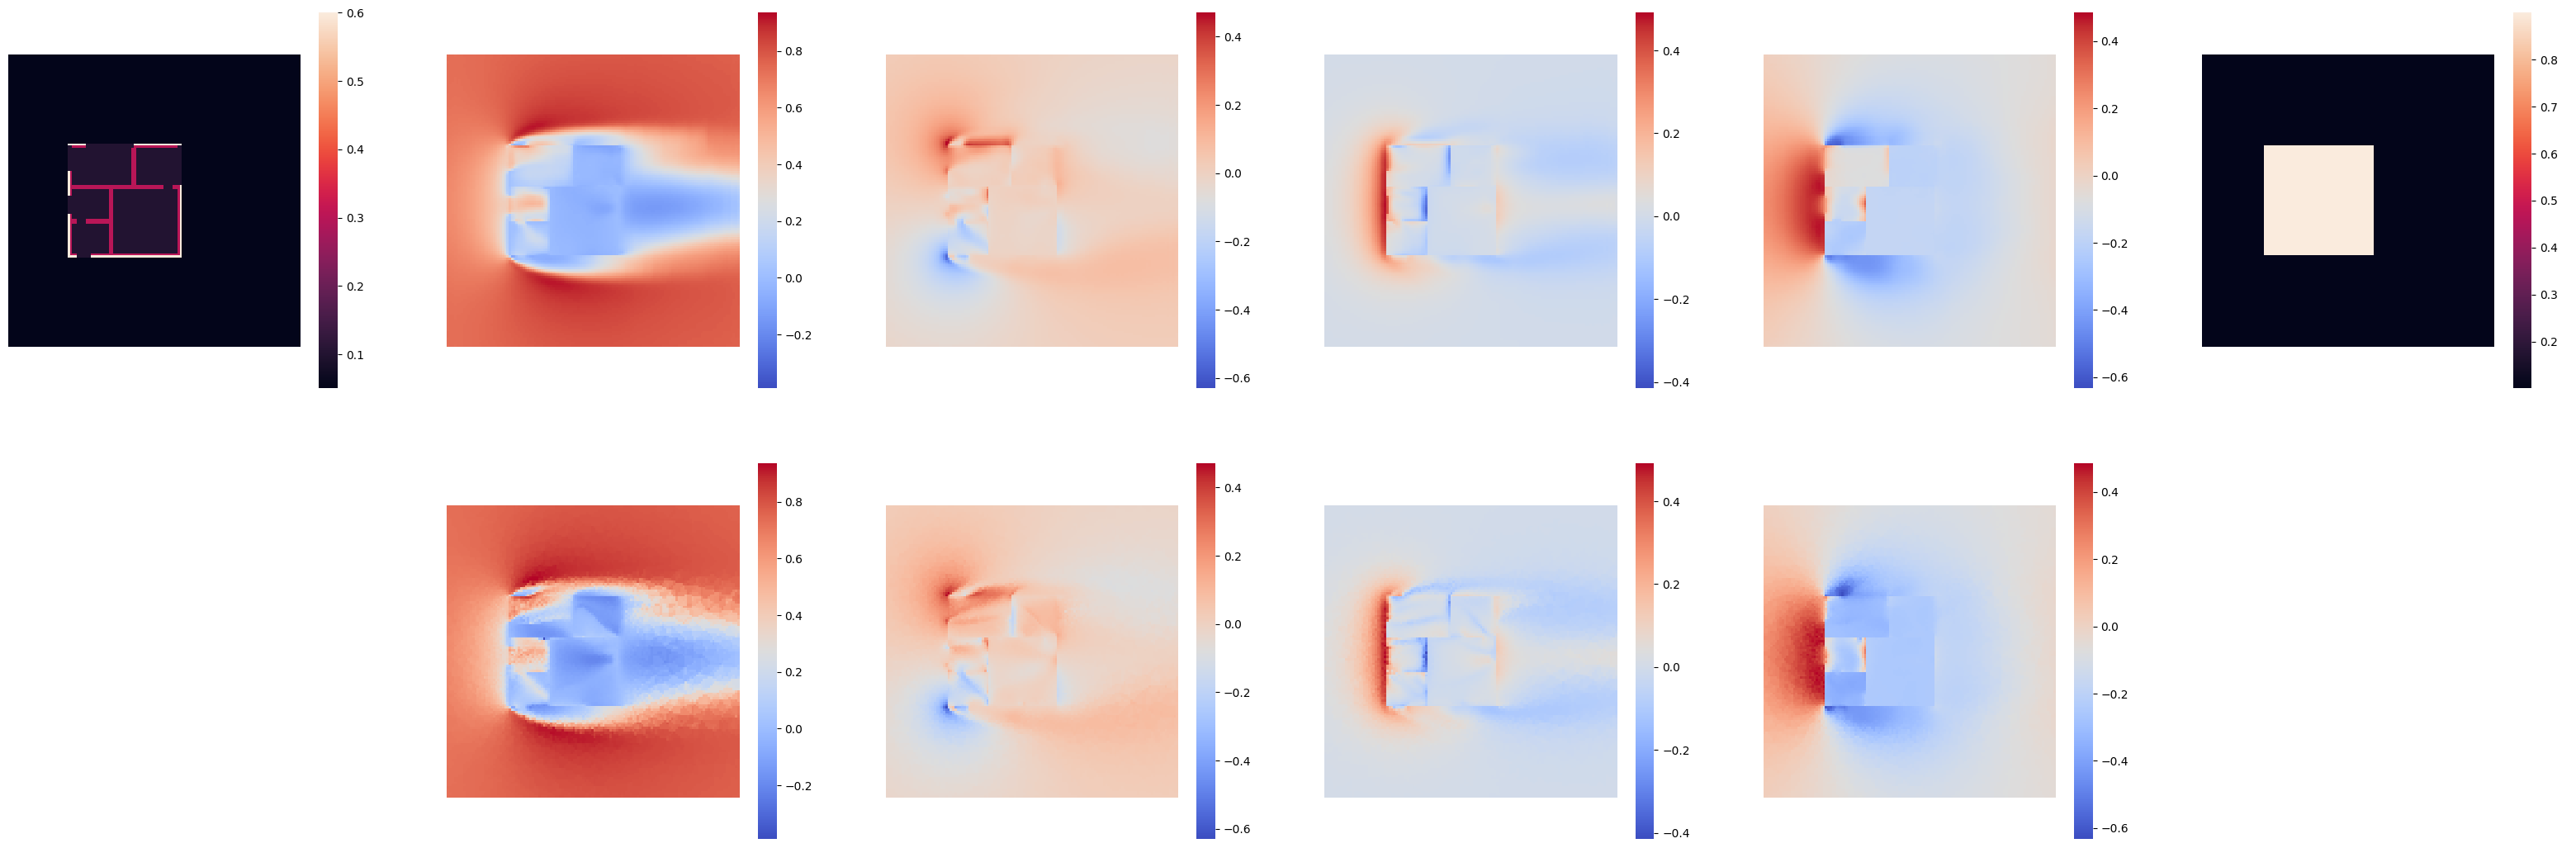

In [10]:
# print data example
z = 10
for comp_mx, cfd_mx in ds_test.skip(5).take(1):
    bnd, u1, v1, w1, p1, mask = comp_mx.numpy()[0,:,:,:,0], comp_mx.numpy()[0,:,:,:,1], comp_mx.numpy()[0,:,:,:,2], comp_mx.numpy()[0,:,:,:,3], comp_mx.numpy()[0,:,:,:,4], comp_mx.numpy()[0,:,:,:,5]
    u2, v2, w2, p2 = cfd_mx.numpy()[0,:,:,:,0], cfd_mx.numpy()[0,:,:,:,1], cfd_mx.numpy()[0,:,:,:,2], cfd_mx.numpy()[0,:,:,:,3]

    u_min, u_max = np.amin(u2[:,:,z], axis=(0,1)), np.amax(u2[:,:,z], axis=(0,1))
    v_min, v_max = np.amin(v2[:,:,z], axis=(0,1)), np.amax(v2[:,:,z], axis=(0,1))
    w_min, w_max = np.amin(w2[:,:,z], axis=(0,1)), np.amax(w2[:,:,z], axis=(0,1))
    p_min, p_max = np.amin(p2[:,:,z], axis=(0,1)), np.amax(p2[:,:,z], axis=(0,1))

    fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(40, 13))
    sns.heatmap(bnd[:,:,z].T, ax = ax[0,0], square = True)
    ax[0,0].invert_yaxis()
    ax[0,0].axis('off')
    sns.heatmap(u1[:,:,z].T, ax = ax[0,1], square = True, cmap="coolwarm", vmin=u_min, vmax=u_max)
    ax[0,1].invert_yaxis()
    ax[0,1].axis('off')
    sns.heatmap(v1[:,:,z].T, ax = ax[0,2], square = True, cmap="coolwarm", vmin=v_min, vmax=v_max)
    ax[0,2].invert_yaxis()
    ax[0,2].axis('off')
    sns.heatmap(w1[:,:,z].T, ax = ax[0,3], square = True, cmap="coolwarm", vmin=w_min, vmax=w_max)
    ax[0,3].invert_yaxis()
    ax[0,3].axis('off')
    sns.heatmap(p1[:,:,z].T, ax = ax[0,4], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
    ax[0,4].invert_yaxis()
    ax[0,4].axis('off')
    sns.heatmap(mask[:,:,z].T, ax = ax[0,5], square = True)
    ax[0,5].invert_yaxis()
    ax[0,5].axis('off')

    ax[1,0].axis('off')
    sns.heatmap(u2[:,:,z].T, ax = ax[1,1], square = True, cmap="coolwarm", vmin=u_min, vmax=u_max)
    ax[1,1].invert_yaxis()
    ax[1,1].axis('off')
    sns.heatmap(v2[:,:,z].T, ax = ax[1,2], square = True, cmap="coolwarm", vmin=v_min, vmax=v_max)
    ax[1,2].invert_yaxis()
    ax[1,2].axis('off')
    sns.heatmap(w2[:,:,z].T, ax = ax[1,3], square = True, cmap="coolwarm", vmin=w_min, vmax=w_max)
    ax[1,3].invert_yaxis()
    ax[1,3].axis('off')
    sns.heatmap(p2[:,:,z].T, ax = ax[1,4], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
    ax[1,4].invert_yaxis()
    ax[1,4].axis('off')
    ax[1,5].axis('off')

In [11]:
generator = define_generator()
generator_optimizer = Adam(0.0000002, beta_1=0.9) # learning rate start as 0.00002 # 50ep 0.000002 # 70ep 0.0000002

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Generator Summary: 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #     Connected to        
 input_1 (InputLayer)                  [(None, 128, 128, 32, 4)   0           []                  
                                       ]                                                          
                                                                                                  
 conv3d (Conv3D)                       (None, 128, 128, 32, 128   13952       ['input_1[0][0]']   
                                       )                                                          
                                                                                                  
 batch_normalization (BatchNormalizat  (None, 128, 128, 32, 128   512         ['conv3d[0][0]']    
 ion)                                  )                                 

In [12]:
@tf.function
def resnet_train_iteration(comp_mx, cfd_mx):
    with tf.GradientTape() as gen_tape:
        loss_factor = 10.0
        generated_images = generator(comp_mx[:,:,:,:,:4])
        mae = MeanAbsoluteError()(generated_images, cfd_mx, sample_weight=comp_mx[:,:,:,:,-1])
        prop = tf.math.reduce_mean(comp_mx[:,:,:,:,-1])
        mae_loss = tf.math.divide(mae, prop)
        gen_loss = mae_loss*loss_factor

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss

In [13]:
def train(dataset, epochs, starting_epoch=0): # mode = "resnet" or "gan"
    f_gen = open("/content/drive/MyDrive/Regularizer_model_0109/regularizer_gen_loss_0801_" + str(starting_epoch) + ".csv", "w")
    writer = csv.writer(f_gen)
    writer.writerow(list(range(train_num)))
    f_gen.close()

    for epoch in range(epochs):
        gen_loss_list = []
        dis_loss_list = []
        start = time.time()

        for i, (comp_mx, cfd_mx) in enumerate(dataset):
            gen_loss = resnet_train_iteration(comp_mx, cfd_mx)
            print('>%d, g[%.4f]' % (i+1, gen_loss))
            gen_loss_list.append(gen_loss.numpy())
        with open('/content/drive/MyDrive/Regularizer_model_0109/regularizer_gen_loss_0801_' + str(starting_epoch) + '.csv', 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(gen_loss_list)

        # save the model every 10 epochs
        if (epoch+1) % 2 == 0:
            g_filename = '/content/drive/MyDrive/Regularizer_model_0109/Archive_models/0801/regularizer_gen_model_0801_%06d.h5' % (starting_epoch+epoch+1)
            generator.save(g_filename)
            print('>save g_model: %s' % (g_filename))
        print('Time for epoch {} is {} sec'.format(starting_epoch + epoch + 1, time.time()-start))

In [ ]:
train(ds_train, epochs=2, starting_epoch=80)

>1, g[0.0676]
>2, g[0.0675]
>3, g[0.0745]
>4, g[0.0675]
>5, g[0.0656]
>6, g[0.0670]
>7, g[0.0704]
>8, g[0.0739]
>9, g[0.0738]
>10, g[0.0756]
>11, g[0.0689]
>12, g[0.0754]
>13, g[0.0677]
>14, g[0.0656]
>15, g[0.0736]
>16, g[0.0738]
>17, g[0.0721]
>18, g[0.0680]
>19, g[0.0747]
>20, g[0.0671]
>21, g[0.0682]
>22, g[0.0620]
>23, g[0.0762]
>24, g[0.0778]
>25, g[0.0650]
>26, g[0.0688]
>27, g[0.0783]
>28, g[0.0702]
>29, g[0.0669]
>30, g[0.0692]
>31, g[0.0742]
>32, g[0.0693]
>33, g[0.0668]
>34, g[0.0736]
>35, g[0.0799]
>36, g[0.0739]
>37, g[0.0745]
>38, g[0.0725]
>39, g[0.0669]
>40, g[0.0749]
>41, g[0.0658]
>42, g[0.0755]
>43, g[0.0713]
>44, g[0.0795]
>45, g[0.0714]
>46, g[0.0755]
>47, g[0.0782]
>48, g[0.0769]
>49, g[0.0730]
>50, g[0.0667]
>51, g[0.0690]
>52, g[0.0667]
>53, g[0.0743]
>54, g[0.0751]
>55, g[0.0761]
>56, g[0.0706]
>57, g[0.0717]
>58, g[0.0748]
>59, g[0.0729]
>60, g[0.0655]
>61, g[0.0731]
>62, g[0.0768]
>63, g[0.0751]
>64, g[0.0755]
>65, g[0.0844]
>66, g[0.0726]
>67, g[0.0725]
>68,

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>1188, g[0.0723]
>save g_model: /content/drive/MyDrive/Regularizer_model_0109/Archive_models/0801/regularizer_gen_model_0801_000080.h5
Time for epoch 80 is 2231.489506959915 sec


In [14]:
g_filename = "/content/drive/MyDrive/Regularizer_model_0109/Archive_models/0801/regularizer_gen_model_0801_000080.h5"
generator = load_model(g_filename, compile=False)

In [ ]:
batch_ind = 6
for comp_mx, cfd_mx in ds_test.skip(batch_ind).take(1):
# for comp_mx, cfd_mx in ds_train.skip(batch_ind).take(1):
    pred_mx = generator.predict(comp_mx[0:1,:,:,:,:-1])

1/1 [==============================] - 11s 11s/step


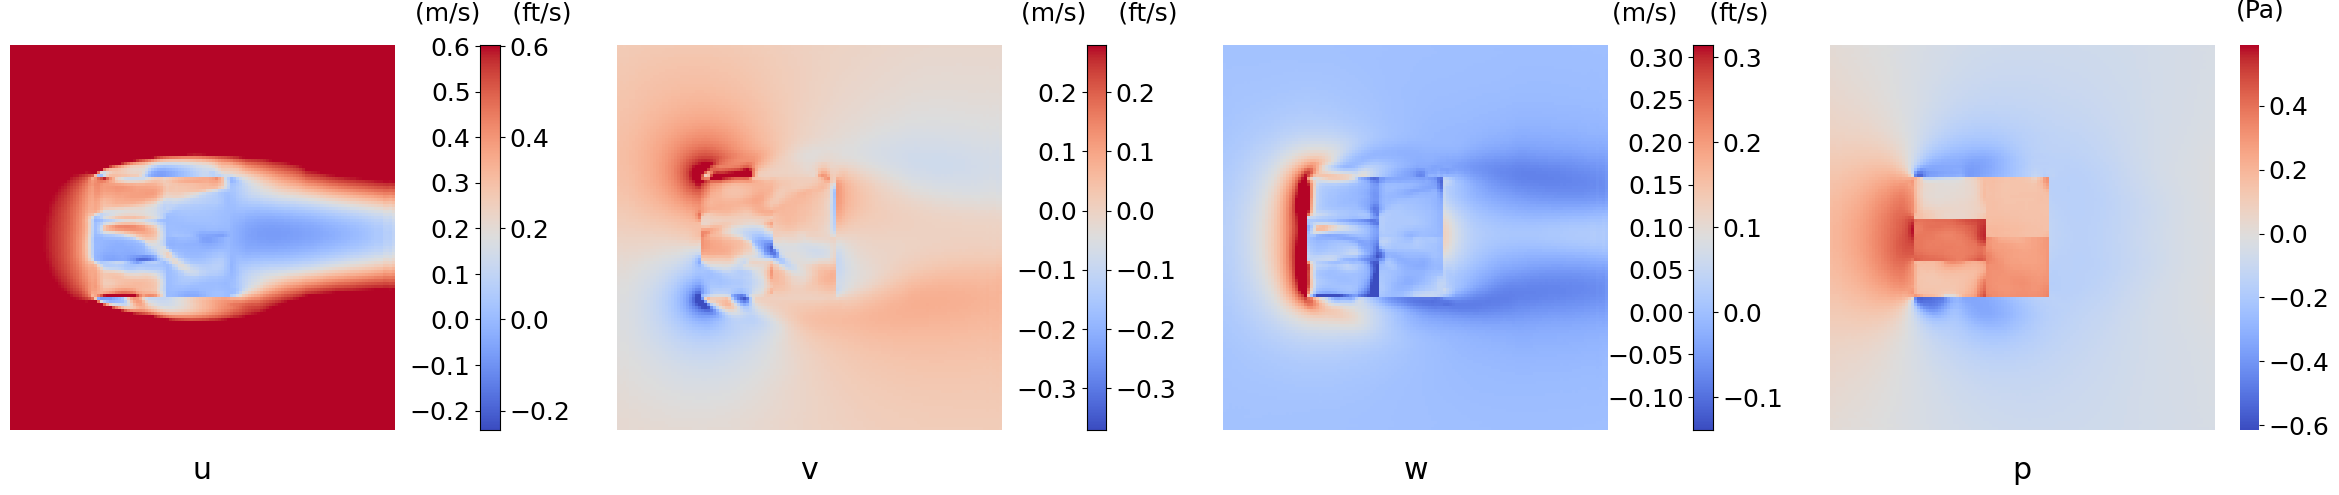

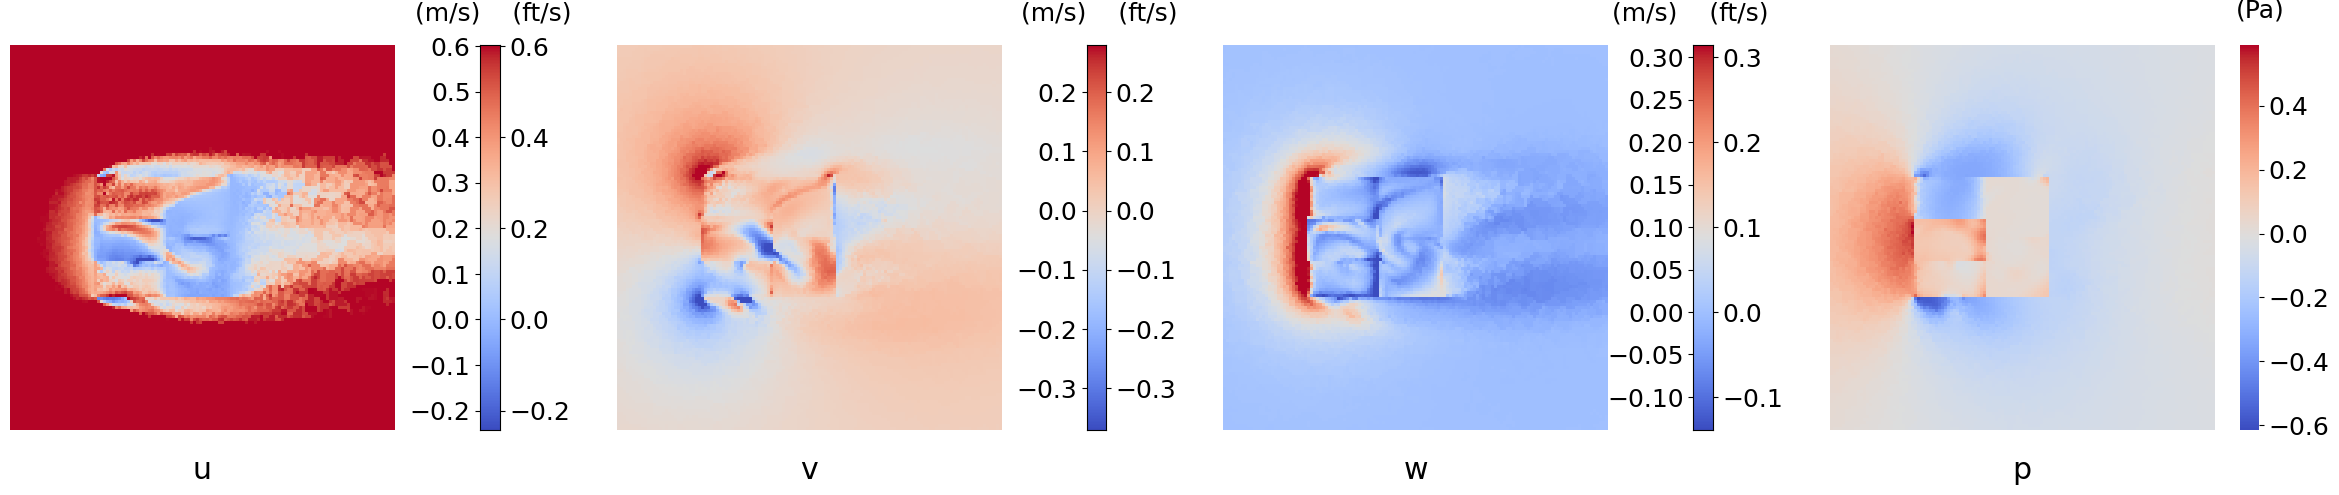

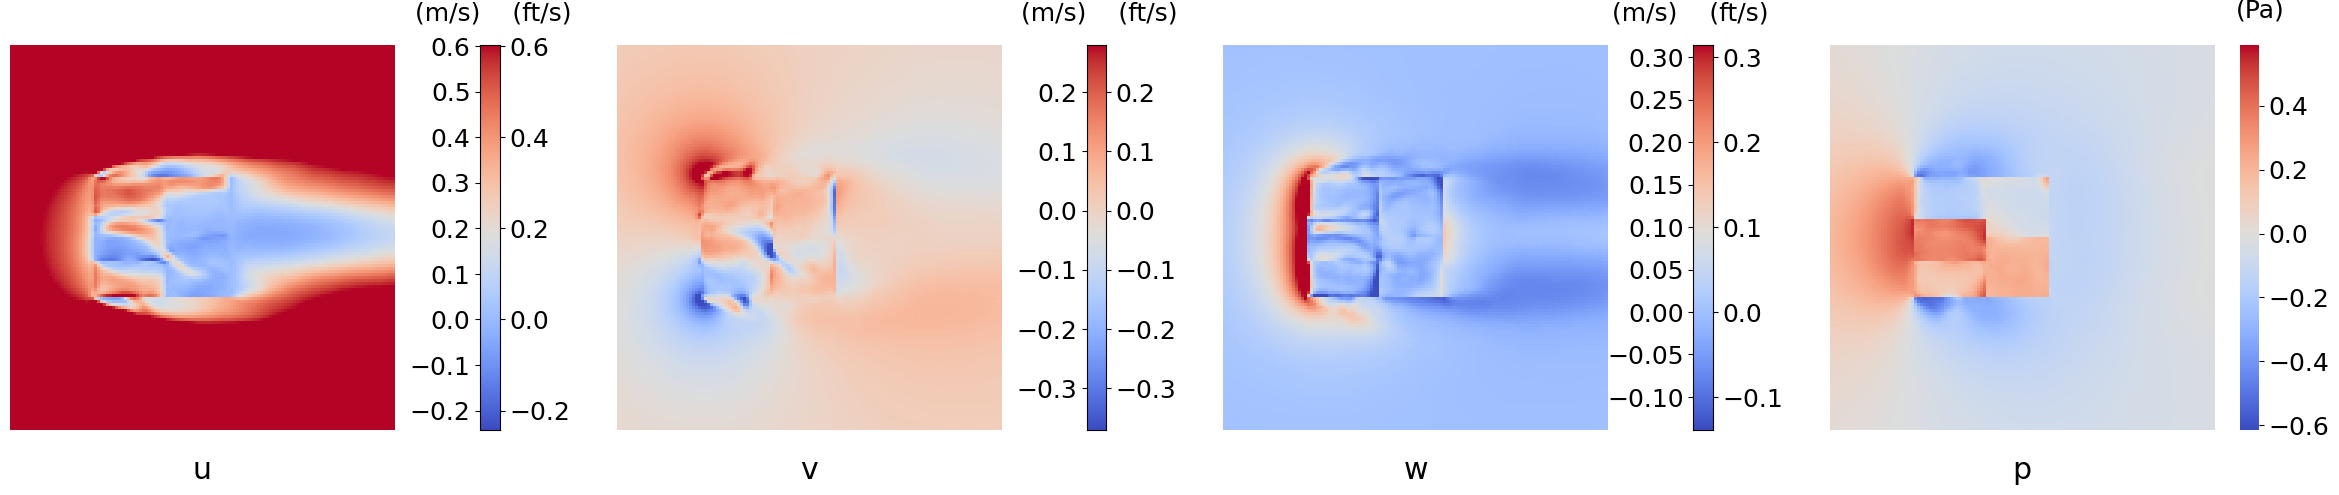

In [ ]:
z = 10 # 0~16
matplotlib.rcParams.update({'font.size': 18})

u_min, u_max = np.amin(cfd_mx[0,:,:,z,0], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,0], axis=(0,1))
v_min, v_max = np.amin(cfd_mx[0,:,:,z,1], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,1], axis=(0,1))
w_min, w_max = np.amin(cfd_mx[0,:,:,z,2], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,2], axis=(0,1))
p_min, p_max = np.amin(cfd_mx[0,:,:,z,3], axis=(0,1)), np.amax(cfd_mx[0,:,:,z,3], axis=(0,1))
bnds = [[u_min/1.5, u_max/1.5], [v_min/1.5, v_max/1.5], [w_min/1.5, w_max/1.5], [p_min/1.5, p_max/1.5]]
# bnds = [[u_min, u_max], [v_min, v_max], [w_min, w_max], [p_min, p_max]]
uvw = ["u", "v", "w"]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
for i in range(3):
    ax[i] = sns.heatmap(comp_mx.numpy()[0,:,:,z,i+1].T, ax = ax[i], square = True, cmap="coolwarm", vmin=bnds[i][0], vmax=bnds[i][1])
    ax[i].invert_yaxis()
    ax[i].axis('off')
    ax[i].set_title(uvw[i], y=-0.15)
    ax[i].collections[0].colorbar.ax.locator_params(nbins=10)
    cbar0 = ax[i].collections[0].colorbar

    pos = cbar0.ax.get_position()
    # print(cbar0.ax.get_yticks())
    # print(cbar0.ax.get_ylim())
    #newpos = np.interp(cbar0.ax.get_yticks(), cbar0.ax.get_ylim(), cbar0.get_clim())
    #newlabel = (newpos*3.28084).round(2)

    pos.x0 += 0.02
    pos.x1 += 0.02
    ax1 = cbar0.ax
    ax1.set_aspect('auto')
    ax1.set_position(pos)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_label_position('left')
    ax1.set_ylabel('(m/s)    (ft/s)', rotation=0, labelpad=-60, y=1.05)

    ax2 = ax1.twinx()
    ax2.set_position(pos)
    ax2.set_ylim([bnds[i][0], bnds[i][1]])
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position('right')
    #ax2.set_yticks(newpos)
    #ax2.set_yticklabels(newlabel)

ax[3] = sns.heatmap(comp_mx.numpy()[0,:,:,z,4].T, ax = ax[3], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
ax[3].invert_yaxis()
ax[3].axis('off')
ax[3].set_title("p", y=-0.15)
# ax[3].collections[0].colorbar.outline.set_visible(True)
cbar3 = ax[3].collections[0].colorbar
cbar3.ax.set_ylabel('(Pa)', rotation=0, labelpad=-50, y=1.12)
cbar3.ax.locator_params(nbins=10)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
for i in range(3):
    ax[i] = sns.heatmap(cfd_mx.numpy()[0,:,:,z,i].T, ax = ax[i], square = True, cmap="coolwarm", vmin=bnds[i][0], vmax=bnds[i][1])
    ax[i].invert_yaxis()
    ax[i].axis('off')
    ax[i].set_title(uvw[i], y=-0.15)
    ax[i].collections[0].colorbar.ax.locator_params(nbins=10)
    cbar0 = ax[i].collections[0].colorbar

    pos = cbar0.ax.get_position()
    # print(cbar0.ax.get_yticks())
    # print(cbar0.ax.get_ylim())
    #newpos = np.interp(cbar0.ax.get_yticks(), cbar0.ax.get_ylim(), cbar0.get_clim())
    #newlabel = (newpos*3.28084).round(2)

    pos.x0 += 0.02
    pos.x1 += 0.02
    ax1 = cbar0.ax
    ax1.set_aspect('auto')
    ax1.set_position(pos)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_label_position('left')
    ax1.set_ylabel('(m/s)    (ft/s)', rotation=0, labelpad=-60, y=1.05)

    ax2 = ax1.twinx()
    ax2.set_position(pos)
    ax2.set_ylim([bnds[i][0], bnds[i][1]])
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position('right')
    #ax2.set_yticks(newpos)
    #ax2.set_yticklabels(newlabel)

ax[3] = sns.heatmap(cfd_mx.numpy()[0,:,:,z,3].T, ax = ax[3], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
ax[3].invert_yaxis()
ax[3].axis('off')
ax[3].set_title("p", y=-0.15)
# ax[3].collections[0].colorbar.outline.set_visible(True)
cbar3 = ax[3].collections[0].colorbar
cbar3.ax.set_ylabel('(Pa)', rotation=0, labelpad=-50, y=1.12)
cbar3.ax.locator_params(nbins=10)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 5))
for i in range(3):
    ax[i] = sns.heatmap(pred_mx[0,:,:,z,i].T, ax = ax[i], square = True, cmap="coolwarm", vmin=bnds[i][0], vmax=bnds[i][1])
    ax[i].invert_yaxis()
    ax[i].axis('off')
    ax[i].set_title(uvw[i], y=-0.15)
    ax[i].collections[0].colorbar.ax.locator_params(nbins=10)
    cbar0 = ax[i].collections[0].colorbar

    pos = cbar0.ax.get_position()
    #newpos = np.interp(cbar0.ax.get_yticks(), cbar0.ax.get_ylim(), cbar0.get_clim())
    #newlabel = (newpos*3.28084).round(2)

    pos.x0 += 0.02
    pos.x1 += 0.02
    ax1 = cbar0.ax
    ax1.set_aspect('auto')
    ax1.set_position(pos)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_label_position('left')
    ax1.set_ylabel('(m/s)    (ft/s)', rotation=0, labelpad=-60, y=1.05)

    ax2 = ax1.twinx()
    ax2.set_position(pos)
    ax2.set_ylim([bnds[i][0], bnds[i][1]])
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position('right')
    #ax2.set_yticks(newpos)
    #ax2.set_yticklabels(newlabel)

ax[3] = sns.heatmap(pred_mx[0,:,:,z,3].T, ax = ax[3], square = True, cmap="coolwarm", vmin=p_min, vmax=p_max)
ax[3].invert_yaxis()
ax[3].axis('off')
ax[3].set_title("p", y=-0.15)
cbar3 = ax[3].collections[0].colorbar
cbar3.ax.set_ylabel('(Pa)', rotation=0, labelpad=-50, y=1.12)
cbar3.ax.locator_params(nbins=10)

In [ ]:
csv_file_pth = "/content/drive/MyDrive/Regularizer_model_0109/regularizer_gen_loss_0801_12.csv"
df = pd.read_csv(csv_file_pth)
df

,0,1,2,3,4,5,6,7,8,9,...,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187
0,0.194471,0.204823,0.203955,0.177448,0.234577,0.186068,0.183954,0.194994,0.215437,0.198592,...,0.170316,0.172712,0.210783,0.154758,0.220757,0.176448,0.217508,0.215677,0.208003,0.201363
1,0.173053,0.174442,0.190114,0.164911,0.219242,0.162456,0.181782,0.182750,0.183268,0.202831,...,0.176257,0.189775,0.198187,0.165730,0.252141,0.198156,0.233439,0.199489,0.204041,0.190135
2,0.168591,0.195810,0.229041,0.177426,0.234779,0.167584,0.175838,0.194765,0.181266,0.196979,...,0.173451,0.180268,0.200753,0.189552,0.210132,0.198988,0.211342,0.186902,0.203645,0.213459
3,0.210400,0.179389,0.183590,0.161194,0.195016,0.152152,0.222965,0.212483,0.176455,0.174337,...,0.171466,0.182020,0.181942,0.169779,0.211984,0.171529,0.187907,0.177233,0.178460,0.185519


<Axes: >

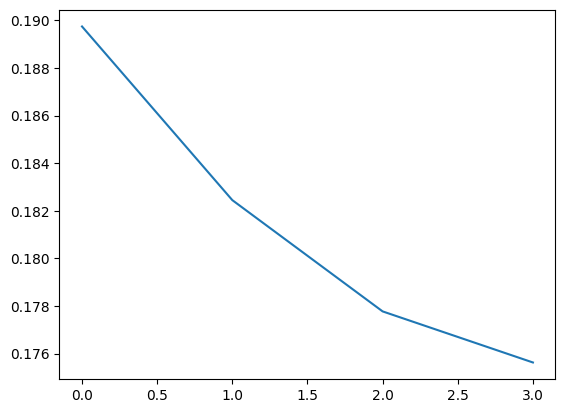

In [ ]:
df.mean(axis=1).plot()

In [15]:
# tensorflow approach ==========================================
# Create test dataset 600
test_batch_size = 8
test_folder_path = "/content/drive/MyDrive/Accuracy_Baseline_vs_OILR_0307/Regularizer_dataset_testset"
test_600_filelist = sorted(glob.glob(test_folder_path + '/*.npz'), key = lambda path: int(path.replace(".npz","").split("overall_iteration_")[1]))
print(len(test_600_filelist))
ds_600_test = tf.data.Dataset.from_tensor_slices(test_600_filelist)
ds_600_test = ds_600_test.flat_map(get_data_wrapper)
ds_600_test = ds_600_test.map(set_shape)
ds_600_test = ds_600_test.batch(batch_size)

600


In [16]:
# tensorflow approach ==========================================
epoch_list = range(72, 82, 2)
mean_loss_list = []
for k in epoch_list:
    start = time.time()
    g_filename = "/content/drive/MyDrive/Regularizer_model_0109/Archive_models/0801/regularizer_gen_model_0801_%06d.h5" % (k)
    model = load_model(g_filename, compile=False)
    loss_list = []
    for i, (comp_mx, cfd_mx) in enumerate(ds_600_test):
        loss_factor = 10.0
        generated_images = model.predict(comp_mx[:,:,:,:,:4])
        mae = MeanAbsoluteError()(generated_images, cfd_mx, sample_weight=comp_mx[:,:,:,:,-1])
        prop = tf.math.reduce_mean(comp_mx[:,:,:,:,-1])
        gen_loss = tf.math.divide(mae, prop)*loss_factor
        loss_list.append(gen_loss.numpy())
    mean_loss_list.append(np.mean(loss_list))
    print('Time for epoch {} is {} sec'.format(k, time.time()-start))
df = pd.DataFrame({"epoch": epoch_list, "loss": mean_loss_list})
df.to_csv("/content/drive/MyDrive/Regularizer_model_0109/regularizer_test_loss_0801.csv", index=False)

1/1 [==============================] - 0s 30ms/step
Time for epoch 72 is 220.8286952972412 sec
1/1 [==============================] - 0s 30ms/step
Time for epoch 74 is 130.0209629535675 sec
1/1 [==============================] - 0s 35ms/step
Time for epoch 76 is 130.93251991271973 sec
1/1 [==============================] - 0s 32ms/step
Time for epoch 78 is 131.72441720962524 sec
1/1 [==============================] - 0s 31ms/step
Time for epoch 80 is 126.34522724151611 sec


Text(0.5, 1.0, 'Testing Loss Trajectory')

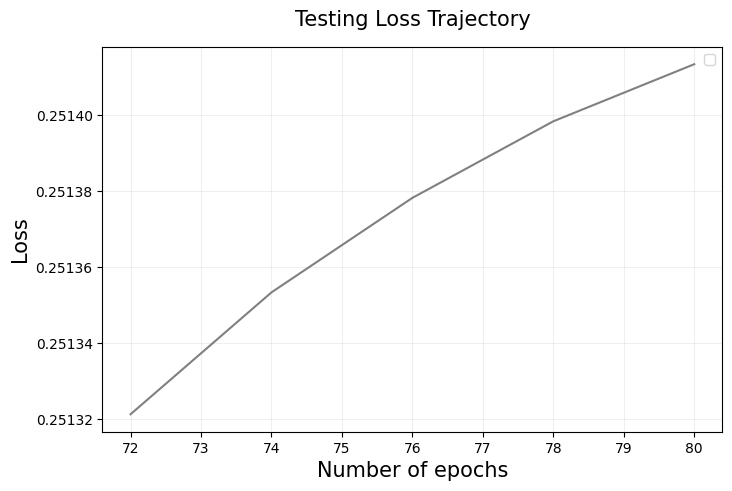

In [17]:
df_test_lost = pd.read_csv("/content/drive/MyDrive/Regularizer_model_0109/regularizer_test_loss_0801.csv")

plt.figure(figsize = (8, 5))
plt.plot(df_test_lost.epoch, df_test_lost.loss, color='grey')
plt.grid(alpha=0.2)
plt.legend(loc='upper right')
plt.grid(alpha=0.2)
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Testing Loss Trajectory', fontsize=15, pad = 15)